## Setup


In [0]:
! [[ -d box-unet ]] || git clone --quiet https://github.com/sdll/box-unet.git

In [3]:
%cd box-unet

/content/box-unet


In [4]:
! [[ -f data.zip ]] || wget https://www.dropbox.com/s/m1ie2zq8nkburar/data.zip?raw=1 -O data.zip && unzip data.zip

--2020-02-25 09:27:48--  https://www.dropbox.com/s/m1ie2zq8nkburar/data.zip?raw=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/m1ie2zq8nkburar/data.zip [following]
--2020-02-25 09:27:48--  https://www.dropbox.com/s/raw/m1ie2zq8nkburar/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6c76afd73cc9c7c1305cb22a1d.dl.dropboxusercontent.com/cd/0/inline/Ayx1ZG-YFOlzt5Tr3hZ18xh49mocKFpuHvfH2QlLVJLKdSoShg7SELJ36pikuiHIbWG7pAa3A61FmADuEoZfLt2ETTW0E_3Gcowoa2hDVjqiYuxAnErnpKsofAyeVAVoDB0/file# [following]
--2020-02-25 09:27:49--  https://uc6c76afd73cc9c7c1305cb22a1d.dl.dropboxusercontent.com/cd/0/inline/Ayx1ZG-YFOlzt5Tr3hZ18xh49mocKFpuHvfH2QlLVJLKdSoShg7SELJ36pikuiHIbWG7pAa3A61FmADuEoZfLt2ETTW0E_3Gcowoa2hDVjqiYuxAnErnp

In [5]:
! pip install -q gsheet-keyring ipython-secrets comet_ml tqdm

     |████████████████████████████████| 184kB 10.3MB/s 
     |████████████████████████████████| 409kB 24.4MB/s 
     |████████████████████████████████| 204kB 33.9MB/s 
     |████████████████████████████████| 2.3MB 33.2MB/s 


In [6]:
! python3 -m pip install -q git+https://github.com/shrubb/box-convolutions.git

## Imports

In [0]:
from comet_ml import Experiment

import argparse
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm as tqdm_base

from box_unet import BoxUNet as Model
from ipython_secrets import get_secret
from pytorch_ssim import ssim

from timeit import default_timer as timer

sns.set()


def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, "_instances"):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

## Environment

In [0]:
DATA_PATH = "data"
GROUND_TRUTH_LABEL = "ground_truth"
NOISY_IMAGES_LABEL = "noisy"
TRAIN_LABEL = "train"
TEST_LABEL = "val"
TRAIN_POSTFIX = "normed_crops.33.tensor"
TEST_POSTFIX = "normalized_data.tensor"
TRAIN_GT_DATA = Path(DATA_PATH) / TRAIN_LABEL / GROUND_TRUTH_LABEL / TRAIN_POSTFIX
TRAIN_NOISY_DATA = Path(DATA_PATH) / TRAIN_LABEL / NOISY_IMAGES_LABEL / TRAIN_POSTFIX
TEST_GT_DATA = Path(DATA_PATH) / TEST_LABEL / GROUND_TRUTH_LABEL / TEST_POSTFIX
TEST_NOISY_DATA = Path(DATA_PATH) / TEST_LABEL / NOISY_IMAGES_LABEL / TEST_POSTFIX
PATCH_SIZE = (33, 33) 
N_CROPS = 64

DEVICE = "cuda"

PROJECT = "fastrino"
COMET_ML_API_KEY = get_secret("comet-{}".format(PROJECT))

In [73]:
experiment = Experiment(
    api_key=COMET_ML_API_KEY,
    project_name=PROJECT,
    workspace=PROJECT,
    auto_output_logging=None,
)

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/fastrino/fastrino/64bf84ce12ed4dd09e69ab952575767f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01       : (9.3, 9.3)
COMET INFO:     sys.cpu.percent.02       : (7.8, 7.8)
COMET INFO:     sys.cpu.percent.avg      : (8.55, 8.55)
COMET INFO:     sys.gpu.0.free_memory    : (14872870912.0, 14872870912.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (17071734784.0, 17071734784.0)
COMET INFO:     sys.gpu.0.used_memory    : (2198863872.0, 2198863872.0)
COMET INFO:     sys.ram.total            : (13655232512.0, 13655232512.0)
COMET INFO:     sys.ram.used             : (6161641472.0, 6161641472.0)
COMET INFO: ----------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/fastrino/fastrino/73dc5a6c39814356941977e22ffde4e3



## Utilities

In [0]:
def get_arg_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--max-input-h", type=int, default=64)
    parser.add_argument("--max-input-w", type=int, default=64)
    parser.add_argument("--lr", type=float, default=1e-4)
    parser.add_argument("--batch-size", type=int, default=32)
    parser.add_argument("--num-epochs", type=int, default=5)
    parser.add_argument("--seed", type=int, default=42)

    return parser


def get_criterion():
    return nn.MSELoss()


def get_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr)


def psnr(prediction, target, max_pixel=255.0):
    return 10.0 * ((max_pixel ** 2) / ((prediction - target) ** 2).mean()).log10()

def compute_padding(img_shape, padding_shape):
    """
    x -> dim=-2
    y -> dim=-1
    """
    return_pad = [0, 0, 0, 0]
    *_, im_x, im_y = img_shape
    pad_x, pad_y = padding_shape

    if (pad_x - (im_x % pad_x)) % 2 == 0:
        return_pad[2] = (pad_x - (im_x % pad_x)) // 2
        return_pad[3] = (pad_x - (im_x % pad_x)) // 2
    else:
        return_pad[2] = (pad_x - (im_x % pad_x)) // 2
        return_pad[3] = (pad_x - (im_x % pad_x)) // 2 + 1

    if (pad_y - (im_y % pad_y)) % 2 == 0:
        return_pad[0] = (pad_y - (im_y % pad_y)) // 2
        return_pad[1] = (pad_y - (im_y % pad_y)) // 2
    else:
        return_pad[0] = (pad_y - (im_y % pad_y)) // 2
        return_pad[1] = (pad_y - (im_y % pad_y)) // 2 + 1
    return return_pad


def split_image(image, patch_size=PATCH_SIZE, n_crops=N_CROPS):
    p_x, p_y = patch_size
    image = F.pad(
        image,
        compute_padding(image.shape, patch_size),
        mode="constant",
        value=image.mean(),
    )
    splits = torch.split(torch.stack(torch.split(image, p_x)), p_y, dim=-1)
    crops = torch.stack(splits, dim=-1)
    crops = crops.view(-1, 1, p_x, p_y)
    crops = torch.split(crops, n_crops, dim=0)
    return crops, image.shape

def combine_crops(crops, shape):
    combined = torch.cat(
        crops, dim=0
    )
    return combined.view(*shape) 

def predict_image(model, image, patch_size=PATCH_SIZE, n_crops=N_CROPS):
    crops, shape = split_image(image, patch_size, n_crops)
    return combine_crops(
        [crop - model(crop.to(DEVICE)).data for crop in crops],
        shape
    )

class PlaneLoader(torch.utils.data.Dataset):
    def __init__(self, gt_data, noisy_data):
        self.gt_data = torch.load(gt_data)
        self.noisy_data = torch.load(noisy_data)

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, index):
        noisy_image = self.noisy_data[index]
        gt_image = self.gt_data[index]
        noise = noisy_image - gt_image
        return (
            noisy_image,
            noise
        )


def train(experiment):
    parser = get_arg_parser()
    args = parser.parse_args(args=[])
    train_loader = torch.utils.data.DataLoader(
        PlaneLoader(TRAIN_GT_DATA, TRAIN_NOISY_DATA),
        batch_size=args.batch_size,
        shuffle=True,
    )

    image, noise = next(iter(train_loader))

    args.in_channels = 1 if len(image.shape) == 3 else image.shape[1]
    experiment.log_parameters(vars(args))

    model = Model(
        args.in_channels, args.in_channels, args.max_input_h, args.max_input_w,
    ).to(DEVICE)

    criterion = get_criterion()
    optimizer = get_optimizer(model, args.lr)

    for epoch in tqdm(range(args.num_epochs), desc="Epoch", unit="epochs"):
        with experiment.train():
            model.train()
            train_psnr = []
            train_ssim = []

            for image, noise in tqdm(train_loader, desc="Train images", unit="images"):
                image = image.to(DEVICE)
                noise = noise.to(DEVICE)

                prediction = model(image)
                loss = criterion(prediction, noise)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                current_psnr = psnr(image - prediction, image - noise).data.item()
                current_ssim = ssim(image - prediction, image - noise).data.item()
                train_psnr.append(current_psnr)
                train_ssim.append(current_ssim)
                experiment.log_metric("psnr", current_psnr)
                experiment.log_metric("ssim", current_ssim)
                experiment.log_metric("loss", loss.data.item())

            experiment.log_metric("mean_psnr", np.mean(train_psnr))
            experiment.log_metric("mean_ssim", np.mean(train_ssim))
    return model

def test(experiment, model, patch_size=PATCH_SIZE, n_crops=N_CROPS):
    test_loader = torch.utils.data.DataLoader(
        PlaneLoader(TEST_GT_DATA, TEST_NOISY_DATA),
        batch_size=1,
        shuffle=False,
    )
    with experiment.test():
        model.eval()
        test_psnr = []
        test_ssim = []
        test_prediction_times = []
        for image, noise in test_loader:
            image = image.to(DEVICE)
            noise = noise.to(DEVICE)
            start = timer()
            prediction = predict_image(model, image, patch_size, n_crops)
            end = timer()
            prediction_time = end - start
            test_prediction_times.append(prediction_time)
            experiment.log_metric("prediction_time", prediction_time)
            gt_image = image - noise
            gt_image_crops, gt_shape = split_image(gt_image)
            gt_image = combine_crops(gt_image_crops, gt_shape)
            assert (
                gt_image.shape == prediction.shape
            ), "Prediction and ground truth do not match in size, aborting."            
            if len(gt_image.shape) == 3:
                gt_image = gt_image[:, None, :, :]
                prediction = prediction[:, None, :, :]
            current_psnr = psnr(prediction, gt_image).data.item()
            current_ssim = ssim(prediction, gt_image).data.item()
            test_psnr.append(current_psnr)
            test_ssim.append(current_ssim)

        test_psnr = np.mean(test_psnr)
        test_ssim = np.mean(test_ssim)
        test_prediction_time = np.mean(test_prediction_times)

        experiment.log_metric("mean_psnr", test_psnr)
        experiment.log_metric("mean_ssim", test_ssim)
        experiment.log_metric("mean_prediction_time", test_prediction_time)

    return test_psnr, test_ssim, test_prediction_time 

In [74]:
model  = train(experiment)

Epoch: 100%|██████████| 5/5 [09:28<00:00, 113.77s/epochs]


In [76]:
test_psnr, test_ssim, test_prediction_time = test(experiment, model)
print(
    "Mean Test PSNR: {}\nMean Test SSIM: {}\nMean Prediction Time: {}".format(
        test_psnr, test_ssim, test_prediction_time
    )
)

Mean Test PSNR: 47.84336358850653
Mean Test SSIM: 0.06659299687387167
Mean Prediction Time: 0.8069175799545188


In [0]:
train_loader = torch.utils.data.DataLoader(
    PlaneLoader(TRAIN_GT_DATA, TRAIN_NOISY_DATA),
    batch_size=1,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    PlaneLoader(TEST_GT_DATA, TEST_NOISY_DATA),
    batch_size=1,
    shuffle=False)


In [0]:
train_it = iter(train_loader)
test_it = iter(test_loader)

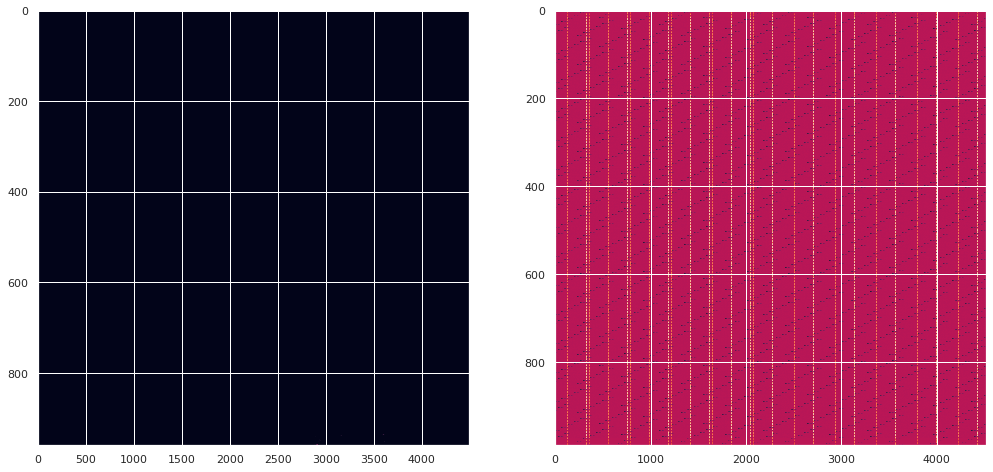

In [85]:
image, noise = next(test_it)
fig = plt.figure(figsize=(17, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow((image - noise).squeeze(), interpolation='nearest', aspect='auto')
ax2.imshow(predict_image(model, image.to(DEVICE)).to("cpu").squeeze(),
           interpolation='nearest', aspect='auto')
plt.show()

In [17]:
image.shape

torch.Size([1, 960, 4492])